In [32]:
import tqdm.notebook as tq
import csv
import os

from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
from torchvision.utils import save_image
import torch
import torch.optim as optim
import torch.nn as nn

import matplotlib.pyplot as plt

cuda:0


In [40]:
path_clone = "/content/"
if not os.path.isdir(path_clone + "irm"):
  %cd $path_clone
  !git clone https://github.com/janezdu/irm.git
else:
  %cd "irm"
  !git pull
  print("Dataset already cloned")

data_path = "irm/data"

print("Device name:",torch.cuda.get_device_name(0))
#  !ls -la "/content/data/"

[Errno 2] No such file or directory: 'irm'
/content/irm
remote: Enumerating objects: 20, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 20 (delta 0), reused 0 (delta 0), pack-reused 17
Unpacking objects: 100% (20/20), done.
From https://github.com/janezdu/irm
   52c23a3..236fa8e  main       -> origin/main
Updating 52c23a3..236fa8e
Fast-forward
 2phase.md                       |   7 +++++++
 images/fixedlinear-1.png        | Bin 0 -> 12498 bytes
 images/losses-may10-meeting.png | Bin 0 -> 10788 bytes
 3 files changed, 7 insertions(+)
 create mode 100644 2phase.md
 create mode 100644 images/fixedlinear-1.png
 create mode 100644 images/losses-may10-meeting.png
Dataset already cloned
Device name: Tesla T4


In [41]:
H, W = 300, 500
transform = transforms.Compose([
    transforms.Resize((H,W)),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])
train = torchvision.datasets.ImageFolder("data/", transform)

In [42]:
train_loader = DataLoader(
    train,
    batch_size=1,
    shuffle=True, 
    # careful when dealing with mixed env points
    num_workers=0,
    collate_fn=None,
    pin_memory=False,
 )

In [43]:
# get waterbirds; returns dict birds
# 1,001.Black_footed_Albatross/Black_Footed_Albatross_0046_18.jpg,1,2,1,/o/ocean/00002178.jpg
# img_id,img_filename,y,split,place,place_filename
def get_place():
    '''
    Gets a dictionary mapping file names to environment ID

    Returns:    
        dict with values (string) filename mapped to
        keys (int) for environment ID*

        *1 corresponds to water environment (ocean) and
        *0 corresponds to land environment

    Example entry:
        # print(get_place())
        # '001.Black_footed_Albatross/Black_Footed_Albatross_0046_18.jpg': 1, 
        # '001.Black_footed_Albatross/Black_Footed_Albatross_0009_34.jpg': 1,	
    '''
    birds = {}
    with open('data/metadata.csv') as f:
        reader = csv.DictReader(f)
        for row in reader:
            fname = row['img_filename'].split('/')[-1]
            birds[fname] = int(row['place'])
    return birds


In [44]:
birds = get_place()

In [45]:
class BasicConvNet(nn.Module):
    '''
    A basic neural network. Not particularly based on anything,
    2 conv layers and last layer is FC.
    '''

    def __init__(self, num_classes, num_envs=2):
        super(BasicConvNet, self).__init__()
        self.conv2d1 = nn.Conv2d(3, 2, 3, 1, 1)
        self.relu = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(2, 2)
        self.conv2d2 = nn.Conv2d(2, 4, 3, 1, 1)
        self.maxpool2 = nn.MaxPool2d(2, 2)
        self.flatten = nn.Flatten()

        # For this part, we want one dense layer for the frist
        # and one dense layer for the second environment
        self.fc1 = nn.Linear(12544, num_classes)
        self.fc2 = nn.Linear(12544, num_classes)
        self._weight_init()

    def _weight_init(self):
        for layer in self.children():
            if (layer.__class__.__name__ == 'Linear' \
                or layer.__class__.__name__ == 'Conv2d'):
                nn.init.kaiming_uniform_(layer.weight.data,0.2)
                nn.init.constant_(layer.bias.data,0)  

    def forward(self, x, env):
        '''
        env: integer parameter. 0 for land, 1 for water
        '''
        x = self.conv2d1(x)
        x = self.relu(x)
        x = self.maxpool1(x)
        x = self.conv2d2(x)
        x = self.relu(x)
        x = self.maxpool2(x)
        x = self.relu(x)
        x = self.flatten(x)

        if env == 1:
            x = self.fc1(x)
        else:
            x = self.fc2(x)
            
        return x

## Phase 1
Train featurizers and classifiers together for all environments.
Both featurizer and classifier should be mutable (are being trained).

Featurizer should be same for samples from all environments,
classifier should be different for samples from different environments.

In [46]:
lr = 0.01
n_epochs = 50
birds = get_place()
net = BasicConvNet(num_classes=2)
optimizer = optim.SGD(net.parameters(), lr=lr)
optimizer.zero_grad()
criterion = nn.CrossEntropyLoss()
losses = torch.Tensor(n_epochs,2)

# need 2 different loss functions. 
# such that they have gradient = 0 on half the weights
# for the irrelevant environment

for epoch in tq.tqdm(range(n_epochs)):
    for batch_idx, data in  enumerate(train_loader):
        inputs, labels = data

        # inputs are currently sorted
        sample_fname, _ = train_loader.dataset.samples[batch_idx]
        fname = sample_fname.split('/')[-1]
        # filename example: Black_Footed_Albatross_0009_34.jpg

        if birds[fname] == 0:
            # Train land-env birds
            optimizer.zero_grad()
            outputs = net(inputs, 0)
            land_loss = criterion(outputs, labels.type(torch.LongTensor)) 
            land_loss.backward()
            optimizer.step()
            
        elif birds[fname] == 1:
            # Train water-env birds
            optimizer.zero_grad()
            outputs = net(inputs, 1)
            water_loss = criterion(outputs, labels.type(torch.LongTensor)) 
            water_loss.backward()
            optimizer.step()
        losses[epoch,0] = land_loss.item()
        losses[epoch,1] = water_loss.item()


    if epoch % 10 == 0:
        print(f"E: {epoch}; Land Loss: {land_loss.item()}; \
            Water Loss: {water_loss.item()}")


  0%|          | 0/50 [00:00<?, ?it/s]

E: 0; Land Loss: 0.6224765777587891;             Water Loss: 0.6208257079124451
E: 10; Land Loss: 0.0006600823253393173;             Water Loss: 0.0038576724473387003
E: 20; Land Loss: 0.004351314157247543;             Water Loss: 4.029192859889008e-05
E: 30; Land Loss: 0.0;             Water Loss: 0.0006518622976727784
E: 40; Land Loss: 9.452849917579442e-05;             Water Loss: 5.566918844124302e-05


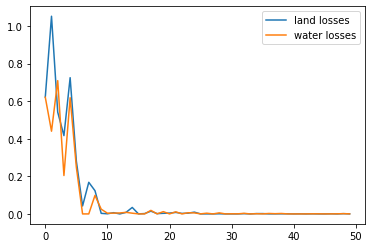

In [47]:
plt.plot(losses[:,0], label="land losses")
plt.plot(losses[:,1], label="water losses")
plt.legend()
plt.show()

In [48]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in net.state_dict():
    print(param_tensor, "\t", net.state_dict()[param_tensor].size())
torch.save(net.state_dict(), "phase1")

Model's state_dict:
conv2d1.weight 	 torch.Size([2, 3, 3, 3])
conv2d1.bias 	 torch.Size([2])
conv2d2.weight 	 torch.Size([4, 2, 3, 3])
conv2d2.bias 	 torch.Size([4])
fc1.weight 	 torch.Size([2, 12544])
fc1.bias 	 torch.Size([2])
fc2.weight 	 torch.Size([2, 12544])
fc2.bias 	 torch.Size([2])


## Phase 2

Train classifiers for environments only, freezing featurizers

In [ ]:
for layer in net.children():
    # unless it's the last linear layer, freeze everything.
    for p in layer.parameters():
        p.requires_grad = False
    if layer.__class__.__name__ == 'Linear':
        # if it's one of the first environment weights, let it train
        for i,p in enumerate(layer.parameters()):
            if i < 2: p.requires_grad=True

for layer in net.children():
    print(layer.__class__.__name__)
    for p in layer.parameters(): 
        # TODO: fix this! It just does weight, bias as the two parameters.
        print("is frozen: ", str(not p.requires_grad))

In [ ]:
l_optim_frozen = optim.SGD(
    filter(lambda p: p.requires_grad, net.parameters()), lr=lr)

for epoch in tq.tqdm(range(n_epochs)):
    for batch_idx, data in enumerate(train_loader):
        inputs, labels = data
        l_optim_frozen.zero_grad()
        outputs = net(inputs)[:,:2] 
        # we're only working with the first weights now 
        loss = criterion(outputs, labels.type(torch.LongTensor)) 
        loss.backward()
        l_optim_frozen.step()


    print(f"E: {epoch}; Land Loss: {land_loss.item()}; Water Loss: {water_loss.item()}")